In [5]:
#Official Phase Space Reconstructed Neural ODEs (PSR-NODE or NODE in general)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy 
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'BABA.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]
    
    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)
    
    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.2473054975271225, Val Loss: 0.2092433124780655
Epoch 10, Train Loss: 0.08035483211278915, Val Loss: 0.061575111001729965
Epoch 20, Train Loss: 0.012961650267243385, Val Loss: 0.00729400385171175
Epoch 30, Train Loss: 0.007169653661549091, Val Loss: 0.007661108858883381
Early stopping triggered at epoch 34
Epoch 0, Train Loss: 0.0049175480380654335, Val Loss: 0.15978646278381348
Epoch 10, Train Loss: 0.0015468749916180968, Val Loss: 0.045272212475538254
Epoch 20, Train Loss: 0.00031867597135715187, Val Loss: 0.006088642869144678
Epoch 30, Train Loss: 0.00012487228377722204, Val Loss: 0.00017185280739795417
Early stopping triggered at epoch 40
Epoch 0, Train Loss: 0.0001404403301421553, Val Loss: 0.001466649817302823
Epoch 10, Train Loss: 0.00025016054860316217, Val Loss: 0.0002255768922623247
Epoch 20, Train Loss: 0.0001636452943785116, Val Loss: 0.00025587546406313777
Epoch 30, Train Loss: 0.00010653987555997446, Val Loss: 0.00017349288100376725
Epoch 40, Train L

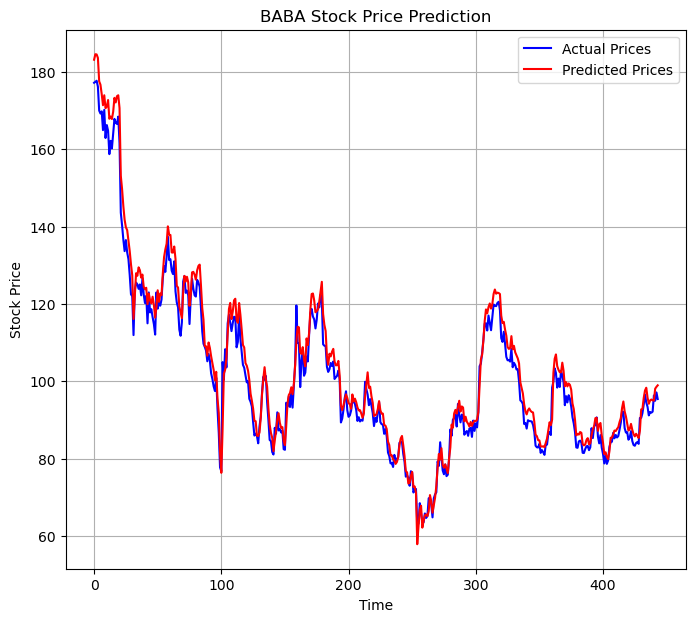

In [6]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('BABA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
#NODE on Lorenz
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy 
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['X', 'Z', 'Y']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'lorenz.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]
    
    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)
    
    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.031677521765232086, Val Loss: 0.01213024090975523
Epoch 10, Train Loss: 0.018023554235696793, Val Loss: 0.008207086473703384
Epoch 20, Train Loss: 0.011805680580437183, Val Loss: 0.005775449797511101
Epoch 30, Train Loss: 0.0075704134069383144, Val Loss: 0.005336094181984663
Epoch 40, Train Loss: 0.005017109680920839, Val Loss: 0.005478003062307835
Early stopping triggered at epoch 44
Epoch 0, Train Loss: 0.005586167797446251, Val Loss: 0.02029300294816494
Epoch 10, Train Loss: 0.004570574499666691, Val Loss: 0.012313221581280231
Epoch 20, Train Loss: 0.004099776037037373, Val Loss: 0.009747159667313099
Epoch 30, Train Loss: 0.003733105259016156, Val Loss: 0.00893093179911375
Epoch 40, Train Loss: 0.003553458023816347, Val Loss: 0.008273957297205925
Epoch 50, Train Loss: 0.0034754746593534946, Val Loss: 0.00799520593136549
Epoch 60, Train Loss: 0.003424743888899684, Val Loss: 0.00790850818157196
Epoch 70, Train Loss: 0.003364474978297949, Val Loss: 0.007768153212

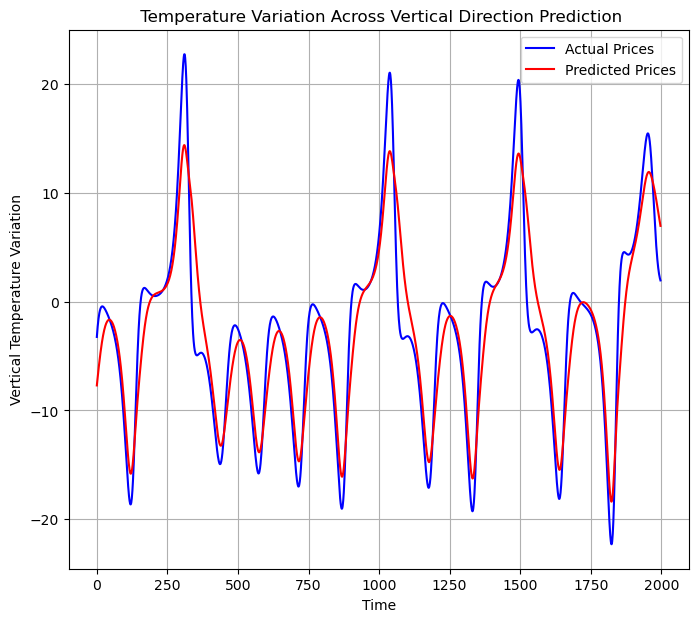

In [4]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title(' Temperature Variation Across Vertical Direction Prediction')
plt.xlabel('Time')
plt.ylabel('Vertical Temperature Variation')
plt.legend()
plt.grid(True)
plt.savefig('lorenz.png', dpi=600)
plt.show()

In [5]:
#NODE on Mackey-Glass 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy 
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['x_t-15', 'x_t-30' ,'x_t-45', 'x_t']]

def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'mackey.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]
    
    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)
    
    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.7121637463569641, Val Loss: 0.6567095518112183
Epoch 10, Train Loss: 0.24578462541103363, Val Loss: 0.21898403763771057
Epoch 20, Train Loss: 0.07759123295545578, Val Loss: 0.07425335049629211
Epoch 30, Train Loss: 0.07553304731845856, Val Loss: 0.07501460611820221
Early stopping triggered at epoch 33
Epoch 0, Train Loss: 0.0705343708395958, Val Loss: 0.06452157348394394
Epoch 10, Train Loss: 0.04269266128540039, Val Loss: 0.03779367730021477
Epoch 20, Train Loss: 0.03243865817785263, Val Loss: 0.027861114591360092
Epoch 30, Train Loss: 0.03138365224003792, Val Loss: 0.026573888957500458
Epoch 40, Train Loss: 0.02945001982152462, Val Loss: 0.02504897303879261
Epoch 50, Train Loss: 0.027798354625701904, Val Loss: 0.024094125255942345
Epoch 60, Train Loss: 0.026488998904824257, Val Loss: 0.0231106486171484
Epoch 70, Train Loss: 0.025191863998770714, Val Loss: 0.021998481824994087
Epoch 80, Train Loss: 0.024042397737503052, Val Loss: 0.021102629601955414
Epoch 90, T

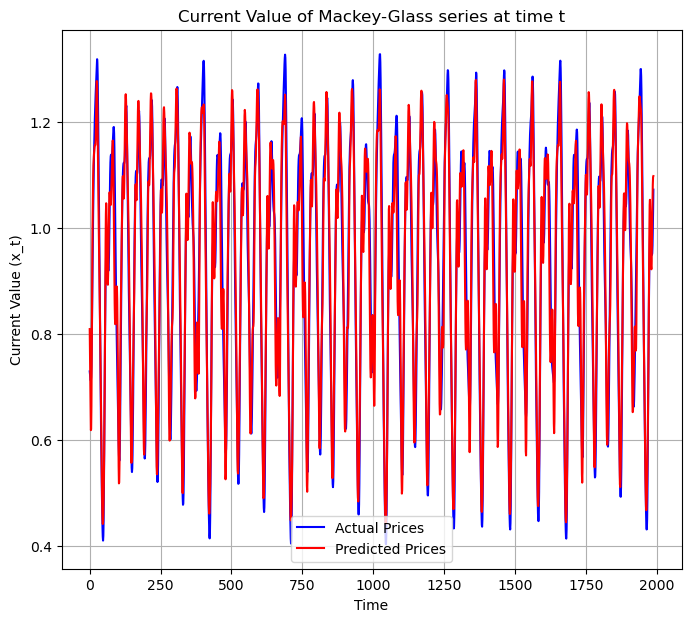

In [8]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('Current Value of Mackey-Glass series at time t')
plt.xlabel('Time')
plt.ylabel('Current Value (x_t)')
plt.legend()
plt.grid(True)
plt.savefig('mackey.png', dpi=600)
plt.show()